In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from transformer import Transformer # this is from the transformer.py file

In [2]:
START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

kannada_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ', 
                      'ँ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 
                      'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ೠ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ', 
                      'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ', 
                      'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ', 
                      'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ', 
                      'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ', 
                      'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ', 
                      'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ', 
                      '಼', 'ಽ', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೣ', 'ಂ', 'ಃ', 
                      '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯', PADDING_TOKEN, END_TOKEN]

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', 
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                        'y', 'z', 
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]

In [3]:
print(kannada_vocabulary)
print(english_vocabulary)

['<START>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ', 'ँ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ೠ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ', 'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ', 'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ', 'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ', 'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ', 'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ', 'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ', '಼', 'ಽ', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೣ', 'ಂ', 'ಃ', '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯', '<PADDING>', '<END>']
['<START>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '<P

In [4]:
index_to_kannada = {k:v for k,v in enumerate(kannada_vocabulary)}
kannada_to_index = {v:k for k,v in enumerate(kannada_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [5]:
print("Index : Kannada")
print(index_to_kannada)
print("\nKannada : Index")
print(kannada_to_index)
print("\n\nIndex : English")
print(index_to_english)
print("\nEnglish : Index")
print(english_to_index)

Index : Kannada
{0: '<START>', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: '+', 13: ',', 14: '-', 15: '.', 16: '/', 17: '0', 18: '1', 19: '2', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9', 27: ':', 28: '<', 29: '=', 30: '>', 31: '?', 32: 'ˌ', 33: 'ँ', 34: 'ఆ', 35: 'ఇ', 36: 'ా', 37: 'ి', 38: 'ీ', 39: 'ు', 40: 'ూ', 41: 'ಅ', 42: 'ಆ', 43: 'ಇ', 44: 'ಈ', 45: 'ಉ', 46: 'ಊ', 47: 'ಋ', 48: 'ೠ', 49: 'ಌ', 50: 'ಎ', 51: 'ಏ', 52: 'ಐ', 53: 'ಒ', 54: 'ಓ', 55: 'ಔ', 56: 'ಕ', 57: 'ಖ', 58: 'ಗ', 59: 'ಘ', 60: 'ಙ', 61: 'ಚ', 62: 'ಛ', 63: 'ಜ', 64: 'ಝ', 65: 'ಞ', 66: 'ಟ', 67: 'ಠ', 68: 'ಡ', 69: 'ಢ', 70: 'ಣ', 71: 'ತ', 72: 'ಥ', 73: 'ದ', 74: 'ಧ', 75: 'ನ', 76: 'ಪ', 77: 'ಫ', 78: 'ಬ', 79: 'ಭ', 80: 'ಮ', 81: 'ಯ', 82: 'ರ', 83: 'ಱ', 84: 'ಲ', 85: 'ಳ', 86: 'ವ', 87: 'ಶ', 88: 'ಷ', 89: 'ಸ', 90: 'ಹ', 91: '಼', 92: 'ಽ', 93: 'ಾ', 94: 'ಿ', 95: 'ೀ', 96: 'ು', 97: 'ೂ', 98: 'ೃ', 99: 'ೄ', 100: 'ೆ', 101: 'ೇ', 102: 'ೈ', 103: 'ೊ', 104: 'ೋ', 105: 'ೌ', 106: '್', 107: 'ೕ', 108: 'ೖ

In [6]:
with open('../datasets/En-Kn/train.en', 'r') as file:
    english_sentences = file.readlines()
with open('../datasets/En-Kn/train.kn', 'r') as file:
    kannada_sentences = file.readlines()

In [7]:
len(english_sentences), len( kannada_sentences)

(4093524, 4093524)

In [8]:
TOTAL_SENTENCES = 50000
english_sentences = english_sentences[:TOTAL_SENTENCES]
kannada_sentences = kannada_sentences[:TOTAL_SENTENCES]
english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
kannada_sentences = [sentence.rstrip('\n') for sentence in kannada_sentences]

In [9]:
len(english_sentences), len( kannada_sentences)

(50000, 50000)

In [10]:
english_sentences[:10]

['hes a scientist.',
 "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha",
 '8 lakh crore have been looted.',
 'i read a lot into this as well.',
 "she was found dead with the phone's battery exploded close to her head the following morning.",
 'how did mankind come under satans rival sovereignty?',
 'and then i became prime minister.',
 'what about corruption?',
 'no differences',
 '"""the shooting of the film is 90 percent done."']

In [11]:
kannada_sentences[:10]

['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.',
 '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"',
 'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.',
 'ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.',
 'ಆಕೆಯ ತಲೆಯ ಹತ್ತಿರ ಇರಿಸಿಕೊಂಡಿದ್ದ ಫೋನ್\u200cನ ಬ್ಯಾಟರಿ ಸ್ಫೋಟಗೊಂಡು ಆಕೆ ಮೃತಪಟ್ಟಿದ್ದಾಳೆ ಎನ್ನಲಾಗಿದೆ.',
 'ಮಾನವಕುಲವು ಸೈತಾನನ ಆಳಿಕೆಯ ಕೆಳಗೆ ಬಂದದ್ದು ಹೇಗೆ?',
 'ನಂತರ ಪ್ರಧಾನಿ ಕೂಡ ಆಗುತ್ತೇನೆ.',
 'ಭ್ರಷ್ಟಾಚಾರ ಏಕಿದೆ?',
 '‘ಅನುಪಾತದಲ್ಲಿ ವ್ಯತ್ಯಾಸವಿಲ್ಲ’',
 'ಆ ಚಿತ್ರದ ಶೇ 90ರಷ್ಟು ಚಿತ್ರೀಕರಣವೂ ಈಗಾಗಲೇ ಮುಗಿದು ಹೋಗಿದೆ.']

In [12]:
max(len(x) for x in kannada_sentences), max(len(x) for x in english_sentences)

(639, 535)

In [13]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length Kannada: {np.percentile([len(x) for x in kannada_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )

97th percentile length Kannada: 173.0
97th percentile length English: 181.0


In [14]:
max_sequence_length = 200

def is_Valid_Tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_Valide_Length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length-1) #need to re-add the <END> token so leaving space for it

valid_sentence_indicies = []

for index in range(len(kannada_sentences)):
    kannada_sentence, english_sentence = kannada_sentences[index], english_sentences[index]
    if is_Valide_Length(kannada_sentence, max_sequence_length) and is_Valide_Length(english_sentence, max_sequence_length) and is_Valid_Tokens(kannada_sentence, kannada_vocabulary):
        valid_sentence_indicies.append(index)
        
# print(valid_sentence_indicies)
print(f"Number of senteces: {len(kannada_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of senteces: 50000
Number of valid sentences: 40827


In [15]:
kannada_sentences = [kannada_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [16]:
kannada_sentences[:5], english_sentences[:5]

(['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.',
  '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"',
  'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.',
  'ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.',
  'ಮಾನವಕುಲವು ಸೈತಾನನ ಆಳಿಕೆಯ ಕೆಳಗೆ ಬಂದದ್ದು ಹೇಗೆ?'],
 ['hes a scientist.',
  "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha",
  '8 lakh crore have been looted.',
  'i read a lot into this as well.',
  'how did mankind come under satans rival sovereignty?'])

In [17]:
import torch

d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 200
kn_vocab_size = len(kannada_vocabulary)

transformer = Transformer(d_model, 
                          ffn_hidden,
                          num_heads, 
                          drop_prob, 
                          num_layers, 
                          max_sequence_length,
                          kn_vocab_size,
                          english_to_index,
                          kannada_to_index,
                          START_TOKEN, 
                          END_TOKEN, 
                          PADDING_TOKEN)

In [18]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, kannada_sentences):
        self.english_sentences = english_sentences
        self.kannada_sentences = kannada_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.kannada_sentences[idx]

In [19]:
dataset = TextDataset(english_sentences, kannada_sentences)

In [20]:
len(dataset)

40827

In [21]:
dataset[:1]

(['hes a scientist.'], ['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.'])

In [22]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [23]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('hes a scientist.', "'but we speak the truth aur ye sach hai ke gujarat mein vikas pagal hogaya hai,'' rahul gandhi further said in banaskantha", '8 lakh crore have been looted.', 'i read a lot into this as well.', 'how did mankind come under satans rival sovereignty?', 'and then i became prime minister.', 'what about corruption?', '"""the shooting of the film is 90 percent done."', 'the special statute', '"then the king said to ittai the gittite, ""why do you also go with us? return, and stay with the king. for you are a foreigner, and also an exile. return to your own place."', 'what happened at the un general assembly?', 'the meeting was attended by prime minister narendra modi, home minister amit shah and defence minister rajnath singh, among others.', 'it has been under discussion for a long time.', 'buses cannot get there.', 'why then this tradition was not thought of?', 'kashmiri youth join indian army', 'basic amenities elude this village', 'off-budget borrowings of the state

In [24]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=kannada_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda


In [25]:
NEG_INFTY = -1e9

def create_masks(eng_batch, kn_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
        eng_sentence_length, kn_sentence_length = len(eng_batch[idx]), len(kn_batch[idx])
        eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
        kn_chars_to_padding_mask = np.arange(kn_sentence_length + 1, max_sequence_length)
        encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
        encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
        decoder_padding_mask_self_attention[idx, :, kn_chars_to_padding_mask] = True
        decoder_padding_mask_self_attention[idx, kn_chars_to_padding_mask, :] = True
        decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
        decoder_padding_mask_cross_attention[idx, kn_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [26]:
#Training with Accuracy for each epoch and final trained transformer

transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 5
accuracy_list = []
f_score_list = []
loss_list = []
precision_list = []
kannada_translation_list = []
kannada_prediction_list = []


for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    total_correct_predictions = 0
    total_predictions = 0
    total_loss = 0

    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, kn_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, kn_batch)
        optim.zero_grad()
        kn_predictions = transformer(eng_batch,
                                    kn_batch,
                                    encoder_self_attention_mask.to(device), 
                                    decoder_self_attention_mask.to(device), 
                                    decoder_cross_attention_mask.to(device),
                                    enc_start_token=False,
                                    enc_end_token=False,
                                    dec_start_token=True,
                                    dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(kn_batch, start_token=False, end_token=True)
        loss = criterian(
            kn_predictions.view(-1, kn_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indices = torch.where(labels.view(-1) == kannada_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indices.sum()
        loss.backward()
        optim.step()
        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(kn_predictions, dim=2)
        num_correct = torch.sum(predictions == labels).item()
        total_correct_predictions += num_correct
        total_predictions += predictions.numel()
        
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Kannada Translation: {kn_batch[0]}")
            kn_sentence_predicted = torch.argmax(kn_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in kn_sentence_predicted:
                if idx == kannada_to_index[END_TOKEN]:
                    break
                predicted_sentence += index_to_kannada[idx.item()]
            print(f"Kannada Prediction: {predicted_sentence}")
            
            # Store Kannada translations and predictions
            kannada_translation_list.append(kn_batch[0])
            kannada_prediction_list.append(predicted_sentence)
            
            reference = [kn_batch[0].split()]  # Actual translation (reference)
            hypothesis = predicted_sentence.split()  # Predicted translation (hypothesis)
            
            # Calculate BLEU score
            bleu_score = corpus_bleu([reference], [hypothesis])
            print(f"Bleu Score: {bleu_score}")
            
            transformer.eval()
            kn_sentence = ("",)
            eng_sentence = ("should we go to the mall?",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, kn_sentence)
                predictions = transformer(eng_sentence,
                                          kn_sentence,
                                          encoder_self_attention_mask.to(device), 
                                          decoder_self_attention_mask.to(device), 
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_kannada[next_token_index]
                kn_sentence = (kn_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                    break
                    
            print(f"Evaluation translation (should we go to the mall?) : {kn_sentence}") #ನಾವು ಮಾಲ್‌ಗೆ ಹೋಗಬೇಕೇ?
            print("-------------------------------------------")
    
    # Calculate precision and F-score
    precision = precision_score(labels.view(-1).cpu(), predictions.view(-1).cpu(), average='weighted', zero_division=1)
    f_score = f1_score(labels.view(-1).cpu(), predictions.view(-1).cpu(), average='weighted')

    start_time = time.time()
    accuracy = total_correct_predictions / total_predictions
    end_time = time.time()
    training_time = end_time - start_time

    print(f"Accuracy after epoch {epoch}: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F-score: {f_score}")
    
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())
    f_score_list.append(f_score)
    precision_list.append(precision)
    


#Final accuracy after training
final_accuracy = total_correct_predictions / total_predictions
print(f"Final Accuracy after training: {final_accuracy}")

Epoch 0
Iteration 0 : 5.727743625640869
English: hes a scientist.
Kannada Translation: ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.
Kannada Prediction: ಝಝಞಫಝಝಝಫಝಞಝಫಝಕಝಝಝ9ಓ9ಫಫಫ9ಓೀಊಓಓ#ಓಞಓ>ಞಮಕಓಓಓ೩೩೩೦ಞ-ೖಕಓಕ೩ಝಞ೩1೩ಥ1ಥ>9ೀಕಙಞೆಞಝಞ>"ಞ>*ಕ-1>>9>>>ೀೀೀ9>ಕ>ೀ111ೆ೩೩೩ೋ೩1ಓ೦ಝూೆ#ుు1೦೦ೀೀೀ#ಝಞ##ుు#ಝಓಝ೦##ಝಝಝ೦ಈಈ111೦ಝೀೀನూ)೦ಈಈಈూಊూಏಊುಝುಝಘ೦೦ಚೀಶು9೦ೀೖಶಥ೦ೀಥಫೀಫಞೀೀಮೀಓ%ಞನಞಚುೀುಊಈుಊುುೀೀೀ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ೆರರಝಝಝಮ      ಕರರರಕ999      ಕಕಕೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆ99ೆೆೆೆ999ೆೆೆೆೆೆೆೆ99ಿಿಿಕಕಕ11ೆೆೆಿ999ಿೆಿಿಿೖೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆೆ11111ೆೆೆೆ    ೆೆಿಿ                  ూూూూ                 999  ೆೆೆೆ                            ',)
-------------------------------------------
Iteration 100 : 3.530055046081543
English: she ate it.
Kannada Translation: ಅವಳು ಅವನಿಗೆ ಊಟ ಹಾಕಿದಳೂ.
Kannada Prediction: ಅ್ದ್   ು ್  ್್್್ಿ
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ದರ್                  ಿ   ಿುಿಿಿ<END>',)
-------------------------------------------
Iteration 200 : 3.308856725692749
English: caste and religion

Evaluation translation (should we go to the mall?) : ('ಆದರೆ ನಿನ್ನು ನಿನ್ನು ನಿರು ನಿರುತ್ತು.<END>',)
-------------------------------------------
Iteration 700 : 2.4077985286712646
English: this will cause heartburn.
Kannada Translation: ಇದು ಎದೆಯುರಿಗೆ ಕಾರಣವಾಗುತ್ತದೆ.
Kannada Prediction: ಅದರ ಕಂ್   ್ ೆ ನಾರ್ ುರಿ ್ತಿೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅದು ಅವರ್ಕೆ ಅವಿಸಿಸಿಸಿಸಿದ್ದಾರೆ.<END>',)
-------------------------------------------
Iteration 800 : 2.3737289905548096
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಆಂರ್ ಮಿ್ ಳ ಸ್್ತೆರಿಮರತ್ಕೆ ೆಂತಿದ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಆದರೆ ಮಾರ್ಯ ಮಾಡಿ ಮಾಡಿಸಿದ್ದಾರೆ.<END>',)
-------------------------------------------
Iteration 900 : 2.386162757873535
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Prediction: ಕಾರಿ ್ ರ

/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/user16/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಅನ್ನು ನಿರುವುದು ಇದು ಇದು?<END>',)
-------------------------------------------
Iteration 800 : 2.190229892730713
English: the government is sinking into debt.
Kannada Translation: ಸಾಲದ ಬಲೆಗೆ ಸರ್ಕಾರ ಸಿಕ್ಕಿಕೊಂಡಿದೆ.
Kannada Prediction: ಅಾಜ್ ಕರ್ ೆ ಮರ್ಥೆರಿಮರಂ್ಷೆ ್ಂಡಿಸೆ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಮಾಡಿದ್ದೇ ಮಾಡುತ್ತಿದೆ.<END>',)
-------------------------------------------
Iteration 900 : 2.204249382019043
English: rajeshwari devi and others participated in this lively programme.
Kannada Translation: ರಾಜೇಶ್ವರಿ ದೇವಿ ಮೊದಲಾದವರು ಉಪಸ್ಥಿತರಿದ್ದರು.
Kannada Prediction: ಕಾಜಿ ್ ಾ್ ಸಾವರ ಕತಲ್್ಗ ರು ಕತ್್ತಿ ್ ಗೆದಾೆ 
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ ಹೇಗೆ?<END>',)
-------------------------------------------
Iteration 1000 : 2.0846126079559326
English: the virus can be passed on through contact with contaminated surfaces.
Kannada Translation:

Iteration 200 : 2.0242867469787598
English: caste and religion were unknown.
Kannada Translation: ಜಾತಿ, ಬೇಧ ಎಂಬುದೇ ಗೊತ್ತಿರಲಿಲ್ಲ.
Kannada Prediction: ಇನಲ್  ನಿಕಿಸಲದುದು ಕುಂ್ತಿ ು್ಲ್ಲ.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಇದು ಹೇಳಿದ್ದರೆ ಹೇಳಿದೆ?<END>',)
-------------------------------------------
Iteration 300 : 2.1104724407196045
English: seeing this, ruler was elated and told his son that the strength of the rabbit is due to the valour of the region's citizenry.
Kannada Translation: ಇದನ್ನು ನೋಡಿ, ಆಡಳಿತಗಾರನು ಉತ್ಸಾಹದಿಂದ ಮತ್ತು ಮೊಲದ ಬಲವು ಪ್ರದೇಶದ ನಾಗರಿಕರ ಶೌರ್ಯದ ಕಾರಣ ಎಂದು ತನ್ನ ಮಗನಿಗೆ ತಿಳಿಸಿದನು.
Kannada Prediction: ಆದರ್ನು ಸಿಡಿನ ಮಸಿಿಗ್ಳಗಿ್ ಮತ್ತ್ತಿೇಂದ ಸತ್ತು ಸಾದೆ ಅ್ಿು ಸ್ರತೇಶದಲಅಿವಳಿಸೊುಸಾಲ್ಮವ್ಅ್ರಿೆಮಂದು ಅ್್ನುಮಾೆ್ಸಳ ಮಿಳ್ಸಿದರ್.
Bleu Score: 0
Evaluation translation (should we go to the mall?) : ('ಅವರು ಅವರು ಹೇಗೆ ಹೇಳಿದ್ದಾರೆ?<END>',)
-------------------------------------------
Iteration 400 : 2.067199468612671
English: i also had such a feeling.
Kannada Translation: ನನಗಂತೂ ಅಂಥ ಅ

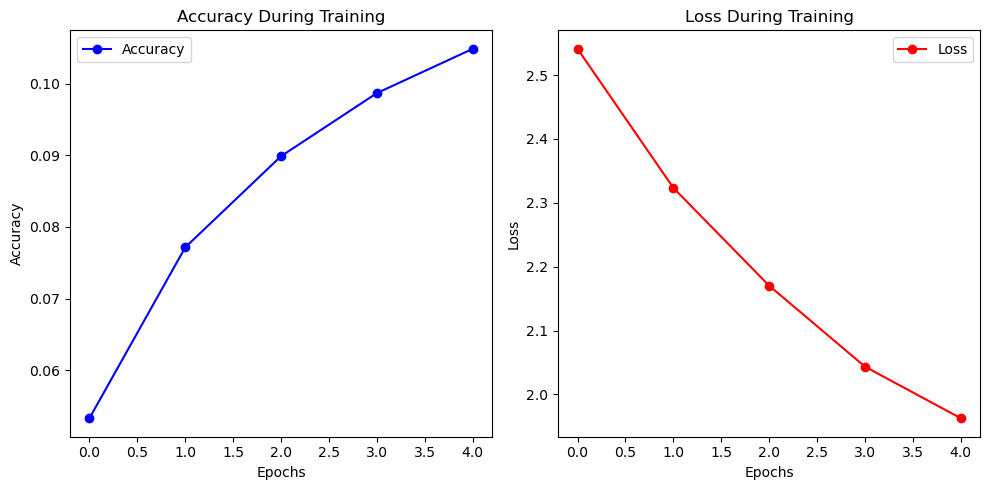

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), accuracy_list, label='Accuracy', color='b', marker='o')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss_list, label='Loss', color='r', marker='o')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

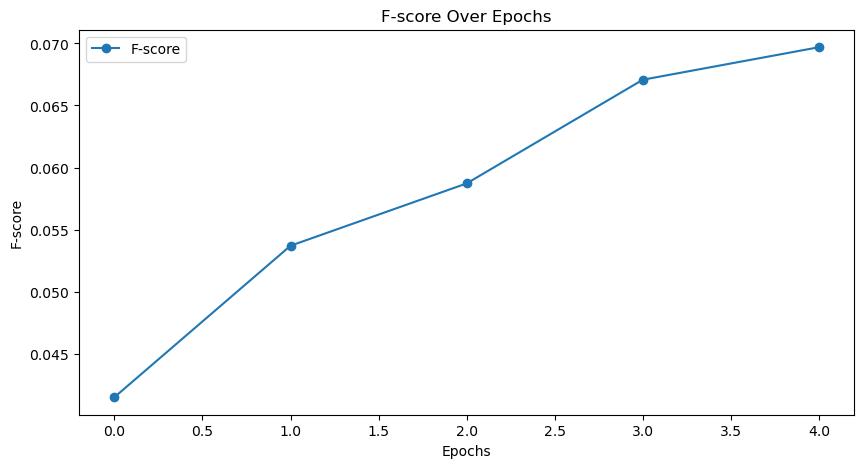

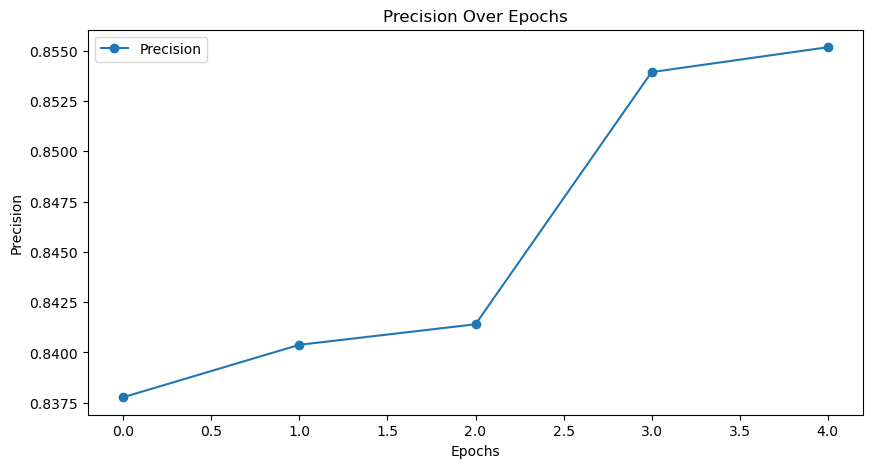

In [28]:
# Plotting F-score
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), f_score_list, label='F-score', marker='o')
plt.title('F-score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F-score')
plt.legend()
plt.show()

# Plotting Precision
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), precision_list, label='Precision', marker='o')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()